In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt


env = gym.make('Blackjack-v0', natural=True)

В нотбуке приведены основные результаты, код исполняемых функций в большинстве своем выделен в модули `agents.py` и `blackjack_with_counting.py`.

# Часть первая, с блекджеком и стратегиями

 1. Рассмотрим очень простую стратегию: говорить stand, если у нас на руках комбинация в 19, 20 или 21 очко, во всех остальных случаях говорить hit. 
Используйте методы Монте-Карло, чтобы оценить выигрыш от этой стратегии.

In [2]:
def simple_policy_loop(n_rounds):
    STOP_SET = (19, 20, 21)
    score = 0
    for _ in range(n_rounds):
        points, _, _ = env.reset()
        done = False
        while not done:
            action = 0 if points in STOP_SET else 1
            observation, reward, done, _ = env.step(action)
            points = observation[0]
        score += reward
    return score / n_rounds

simple_policy_loop(n_rounds=200000)

-0.17781

.2. Реализуйте метод обучения с подкреплением без модели (можно Q-обучение, но рекомендую попробовать и другие, например Monte Carlo control) для обучения стратегии в блекджеке, используя окружение Blackjack-v0 из OpenAI Gym.

Для решения задачи было реализовано Q-обучение, код представлен в модуле `agents.py`.

In [4]:
from agents import BlackjackDefaultAgent

.3. Сколько выигрывает казино у вашей стратегии? Нарисуйте графики среднего дохода вашего метода (усреднённого по крайней мере по 100000 раздач, а лучше больше) по ходу обучения. Попробуйте подобрать оптимальные гиперпараметры.

Ниже приведены также функции для подбора гиперпараметров и для изображения динамики обучения.

In [6]:
def opt_search(agent_type, n_train_episodes=100000, n_test_episodes=100000, env=None):
    best_eps, best_alpha = -1, -1
    best_reward = -1.
    eps_vals = [0.05, 0.1, 0.2, 0.4, 0.5, 0.8]
    alpha_vals = [1e-5, 1e-4, 3e-4, 1e-3, 3e-3, 1e-2]
    for epsilon in eps_vals:
        for alpha in alpha_vals:
            agent = agent_type(epsilon, alpha, env=env)
            reward = agent.learn(
                n_train_episodes=n_train_episodes,
                n_test_episodes=n_test_episodes,
                verbose=n_train_episodes,
                show=False)[0]
            if reward > best_reward:
                best_reward = reward
                best_eps = epsilon
                best_alpha = alpha
                print(
                "Params updated: epsilon={}, alpha={} achieved reward {}".format(
                best_eps, best_alpha, best_reward)
                )
    print(
        "Best reward {} was achieved with epsilon={} and alpha={}".format(
        best_reward, best_eps, best_alpha)
        )
    return best_eps, best_alpha

def learn_dynamics(
    agent,
    n_train_episodes=100000,
    n_test_episodes=100000,
    step=10000):
    rewards = agent.learn(
                n_train_episodes=n_train_episodes,
                n_test_episodes=n_test_episodes,
                verbose=step,
                show=False)
    points = np.arange(step, n_train_episodes+1, step)
    plt.plot(points, rewards)
    plt.grid()
    plt.xlabel("Num expiriments")
    plt.ylabel("Avg reward per episode")

In [8]:
epsilon, alpha = opt_search(BlackjackDefaultAgent, env=None)

Params updated: epsilon=0.05, alpha=1e-05 achieved reward -0.09401
Params updated: epsilon=0.05, alpha=0.0001 achieved reward -0.07858
Params updated: epsilon=0.1, alpha=1e-05 achieved reward -0.072665
Params updated: epsilon=0.1, alpha=0.0001 achieved reward -0.05143
Params updated: epsilon=0.2, alpha=0.001 achieved reward -0.04667
Params updated: epsilon=0.4, alpha=0.0003 achieved reward -0.04343
Params updated: epsilon=0.5, alpha=1e-05 achieved reward -0.04169
Params updated: epsilon=0.5, alpha=0.001 achieved reward -0.04098
Params updated: epsilon=0.8, alpha=1e-05 achieved reward -0.036455
Params updated: epsilon=0.8, alpha=0.0001 achieved reward -0.02868
Best reward -0.02868 was achieved with epsilon=0.8 and alpha=0.0001


Оказалось, что для этой среды требуется высокий exploration. Построим кривую обучения.

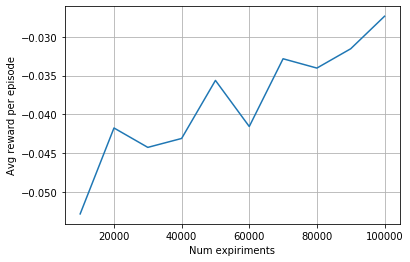

In [16]:
agent = BlackjackDefaultAgent(epsilon, alpha)
learn_dynamics(agent)

Вполне предсказуемо, этого было недостаточно для победы :( Однако результат сильно лучше базовой стратегии.

## Часть вторая, удвоенная

В базовый блекджек, описанный в предыдущем разделе, обыграть казино вряд ли получится. Но, к счастью, на этом история не заканчивается. Описанные выше правила были упрощёнными, а на самом деле у игрока есть ещё и другие возможности. Реализовывать split может оказаться непросто, поэтому давайте ограничимся удвоением ставки. Итак, у игрока появляется дополнительное действие:
double — удвоить ставку; при этом больше действий делать нельзя, игроку выдаётся ровно одна дополнительная карта, а выигрыш или проигрыш удваивается.


.4. Реализуйте новый вариант блекджека на основе окружения Blackjack-v0 из OpenAI Gym, в котором разрешено удвоение ставки.

Пронаследуем базовый класс и переопределим метод `step`, позволив удвоение.

In [10]:
class BlackJackWithDoubling(gym.envs.toy_text.BlackjackEnv):
    def __init__(self, natural=True):
        super().__init__(natural)
        self.action_space = gym.spaces.Discrete(3)
        
    def step(self, action):
        if action == 2:
            # pick one card
            obs, reward, done, info = super().step(1)
            # if not done, i can just stick
            if not done:
                obs, reward, done, info = super().step(0)
            return obs, reward * 2, done, info
        else:
            return super().step(action)

.5. Реализуйте метод обучения с подкреплением без модели для этого варианта, постройте графики, аналогичные п.2.

Класс `BlackjackDefaultAgent` был изначально адаптирован для модифицированного окружения, нужно лишь указать его. Само обучение не отличается.

In [11]:
epsilon, alpha = opt_search(BlackjackDefaultAgent, env=BlackJackWithDoubling())

Params updated: epsilon=0.05, alpha=1e-05 achieved reward -0.11624
Params updated: epsilon=0.05, alpha=0.0001 achieved reward -0.09361
Params updated: epsilon=0.1, alpha=1e-05 achieved reward -0.092935
Params updated: epsilon=0.2, alpha=0.0003 achieved reward -0.06617
Params updated: epsilon=0.4, alpha=1e-05 achieved reward -0.04586
Params updated: epsilon=0.5, alpha=1e-05 achieved reward -0.03599
Params updated: epsilon=0.8, alpha=1e-05 achieved reward -0.03105
Params updated: epsilon=0.8, alpha=0.0001 achieved reward -0.028605
Params updated: epsilon=0.8, alpha=0.0003 achieved reward -0.02236
Best reward -0.02236 was achieved with epsilon=0.8 and alpha=0.0003


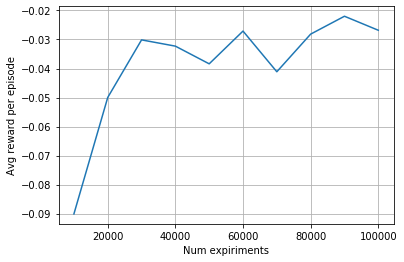

In [14]:
agent = BlackjackDefaultAgent(epsilon, alpha, env=BlackJackWithDoubling())
learn_dynamics(agent)

Удалось получить небольшое преимущество относительно прошлой стратегии, однако, его по прежнему недостаточно для победы.

## Часть третья, в главной роли — Дастин Хоффман

А теперь давайте вспомним, как играют в блекджек настоящие профессионалы. Дело в том, что в оффлайн-казино обычно не перемешивают колоду после каждой раздачи — это слишком замедляло бы игру. После раздачи карты просто раздаются дальше с верха колоды до тех пор, пока карт не останется слишком мало, и только тогда колода перемешивается; давайте для определённости считать, что наше казино будет перемешивать колоду, в которой осталось меньше 15 карт.
Думаю, у вас уже возникла в голове эта картинка:

Действительно, если вы будете запоминать, какие карты уже вышли, у вас будет информация о том, какие карты ещё остались, а это позволяет лучше понять, когда нужно удваивать ставку или делать split, а когда лучше не стоит. В настоящем казино могут раздавать карты сразу из нескольких колод, и заслуга Rain Man’а была в том, что он смог считать карты в шести колодах одновременно. Но мы с вами вооружены компьютерами, так что подсчёт можно считать автоматическим.

*6. Реализуйте вариант окружения Blackjack-v0 из предыдущей части (с удвоением), в котором игрок имеет возможность “считать карты” в колоде. Это можно сделать разными способами; возможно, вам поможет статья википедии о блекджеке (а возможно, и нет).

Для этого пункта пришлось побольше изменить окружение (новое реализовано в модуле `blackjack_with_counting.py`), а также реализовать нового агента (немного изменить реализацию, обучается также Q-обучением.)
Для решения задачи я пробовал реализовать оба метода подсчета (реализация малоотличима), значительной разницы в результате я не заметил и остановился на подсчете половинками.

In [6]:
from blackjack_with_counting import BlackJackWithCounting
from agents import BlackjackCountingAgent

*7. Реализуйте метод обучения с подкреплением без модели для этого варианта, постройте графики, аналогичные п.2.

In [19]:
epsilon, alpha = opt_search(BlackjackCountingAgent, env=BlackJackWithCounting())

Params updated: epsilon=0.05, alpha=1e-05 achieved reward -0.14738
Params updated: epsilon=0.05, alpha=0.0001 achieved reward -0.12878
Params updated: epsilon=0.1, alpha=0.003 achieved reward -0.127225
Params updated: epsilon=0.2, alpha=1e-05 achieved reward -0.12709
Params updated: epsilon=0.2, alpha=0.0001 achieved reward -0.126745
Params updated: epsilon=0.2, alpha=0.003 achieved reward -0.126695
Params updated: epsilon=0.2, alpha=0.01 achieved reward -0.1213
Params updated: epsilon=0.4, alpha=1e-05 achieved reward -0.12008
Params updated: epsilon=0.4, alpha=0.0001 achieved reward -0.117375
Params updated: epsilon=0.4, alpha=0.0003 achieved reward -0.10683
Params updated: epsilon=0.5, alpha=1e-05 achieved reward -0.1052
Params updated: epsilon=0.5, alpha=0.003 achieved reward -0.10382
Params updated: epsilon=0.8, alpha=0.0001 achieved reward -0.101335
Params updated: epsilon=0.8, alpha=0.0003 achieved reward -0.09866
Params updated: epsilon=0.8, alpha=0.001 achieved reward -0.085835

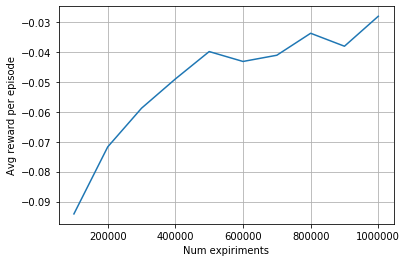

In [11]:
counting_agent = BlackjackCountingAgent(epsilon, alpha, env=BlackJackWithCounting())
learn_dynamics(counting_agent,n_train_episodes=1000000,
    n_test_episodes=100000,
    step=100000)

Поскольку пространство действий и исходов сильно увеличилось, ста тысяч экспериментов стало абсолютно недостаточно. На графике изображена динамика обучения на миллионе экспериментов. В связи с увеличением количества сэмлпов, сравнивать исходы с прошлыми моделями не совсем корректно. Наилучший результат этой реализации был лучше, чем ранее (он не попал на график, но составил чуть менее -0,01). Таким образом, обыграть казино не вышло.